# Splines

- GLM assumption: $g(E[Y|X])= X\beta$, is a linear function of $X$
- This is probably almost never the case
- Why ever assume linearity?
    - Simplicity
    - Interpretability
    - Minimal risk of overfitting
    - First-order Taylor approximation of true $E[Y|X]=f(X)$

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [202]:
# true regression function
def f(x):
    return(2*np.square(x)-50)

n = 500 # sample size
x = np.sort(np.random.uniform(low=0, high=10, size=n))
y = f(x)+np.random.normal(0, 10, n)
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     4993.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):          1.01e-261
Time:                        17:21:36   Log-Likelihood:                -2167.7
No. Observations:                 500   AIC:                             4339.
Df Residuals:                     498   BIC:                             4348.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -82.4384      1.656    -49.777      0.000     -85.692     -79.184
x1            19.8876      0.281     70.663      0.000      19.335      20.441
==============================================================================
Omnibus:                       19.224   Durbin-Watson:                   0.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.484
Skew:                           0.398   Prob(JB):                     0.000160
Kurtosis:                       2.548   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

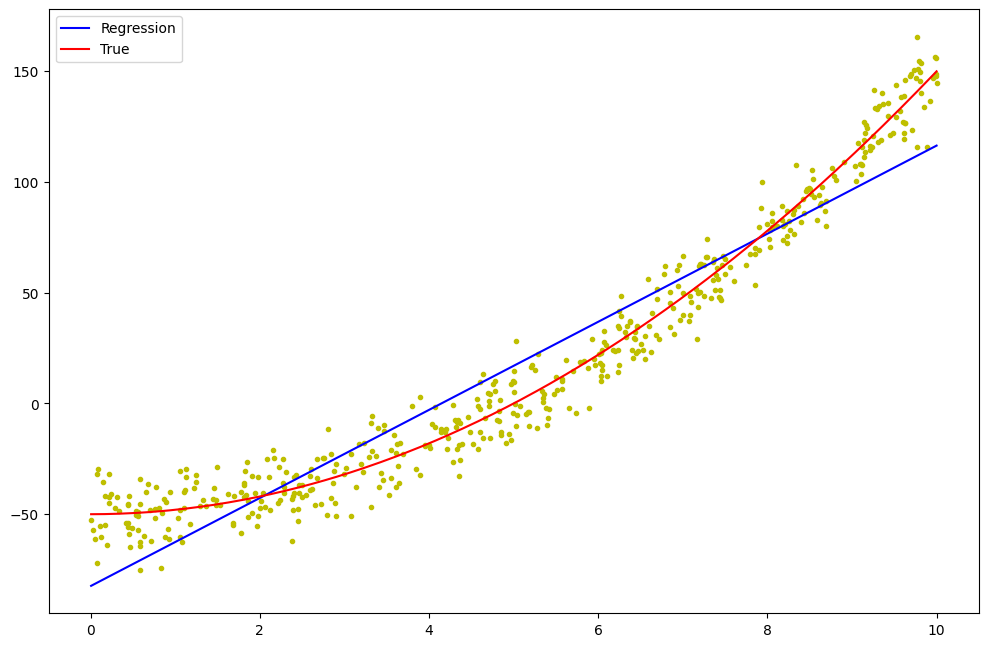

In [203]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(x,y,'.y')
plt.plot(x, x*results.params[1]+results.params[0], '-b',
         label='Regression')
plt.plot(x, f(x), '-r', label='True')
plt.legend();

- Clear that fit is not perfect
- But, it could still be helpful, depending on setting
- Easy to interpret: on average, for each unit increase in x, there is a 20 unit increase in y
- If prediction is the primary objective, this model would not be ideal
- Because this looks quadratic, we could transform x to reflect this
- Including an $x^2$ in the data will improve fit

### Case Study: South African Heart Disease

- Subset of Coronary Risk-Factor Study (CORIS) baseline survey from 1983
- Data collected in 3 rural areas of the Western Cape, South Africa
- Aim: Establish intensity of ischemic heart disease risk factors
- Note: Western Cape is a high-incidence region
- Data: White males between age 15 and 64
- Outcome: myocardial infarction (MI) at time of survey (prevalence 5.1%)
- Why not use proportional hazards regression here?

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

Data dictionary:

- **sbp:** systolic blood pressure
- **tobacco:** cumulative tobacco (kg)
- **ldl:** low densiity lipoprotein cholesterol
- **famhist:** family history of heart disease (Present, Absent)
- **obesity:** body mass index (bmi)
- **age:** age at onset
- **chd:** response, coronary heart disease

**Goal:** For this task, our primary objective is prediction (not inference), but we want to be able to interpret the model as well

In [204]:
url = 'https://web.stanford.edu/~hastie/ElemStatLearn//datasets/SAheart.data'
dat = pd.read_csv(url)
dat = dat[['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age', 'chd']]
print(dat.shape)
dat.head()

(462, 7)


,sbp,tobacco,ldl,famhist,obesity,age,chd
0,160,12.00,5.73,Present,25.30,52,1
1,144,0.01,4.41,Absent,28.87,63,1
2,118,0.08,3.48,Present,29.14,46,0
3,170,7.50,6.41,Present,31.99,58,1
4,134,13.60,3.50,Present,25.99,49,1


In [205]:
dat.describe().round(2)

,sbp,tobacco,ldl,obesity,age,chd
count,462.00,462.00,462.00,462.00,462.00,462.00
mean,138.33,3.64,4.74,26.04,42.82,0.35
std,20.50,4.59,2.07,4.21,14.61,0.48
min,101.00,0.00,0.98,14.70,15.00,0.00
25%,124.00,0.05,3.28,22.98,31.00,0.00
50%,134.00,2.00,4.34,25.80,45.00,0.00
75%,148.00,5.50,5.79,28.50,55.00,1.00
max,218.00,31.20,15.33,46.58,64.00,1.00


- Note: `describe` by default only looks at numeric variables
- Must also look at non-numeric variables as well

In [206]:
print(dat.dtypes)
dat.describe(include='object')

sbp          int64
tobacco    float64
ldl        float64
famhist     object
obesity    float64
age          int64
chd          int64
dtype: object


,famhist
count,462
unique,2
top,Absent
freq,270


- Exploring data
- `seaborn` has some nice exploratory data visualization methods

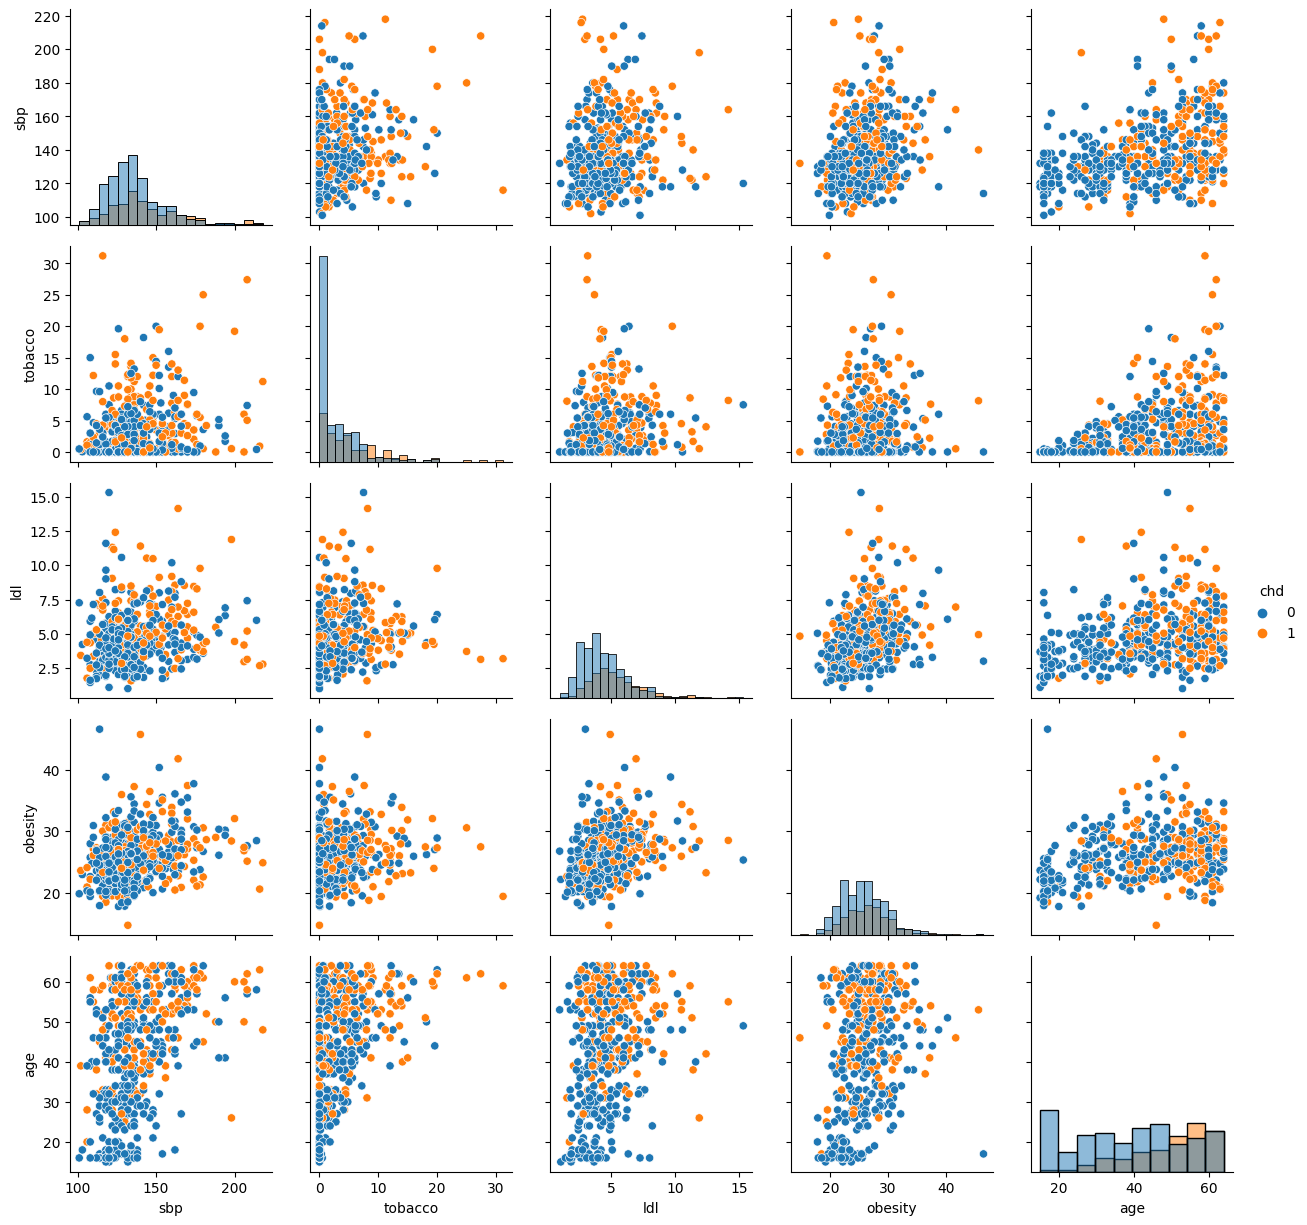

In [207]:
g = sns.PairGrid(dat, hue="chd")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

- **Violin** plots can be more helpful by showing the densities more clearly
- This can be helpful for bimodal densities

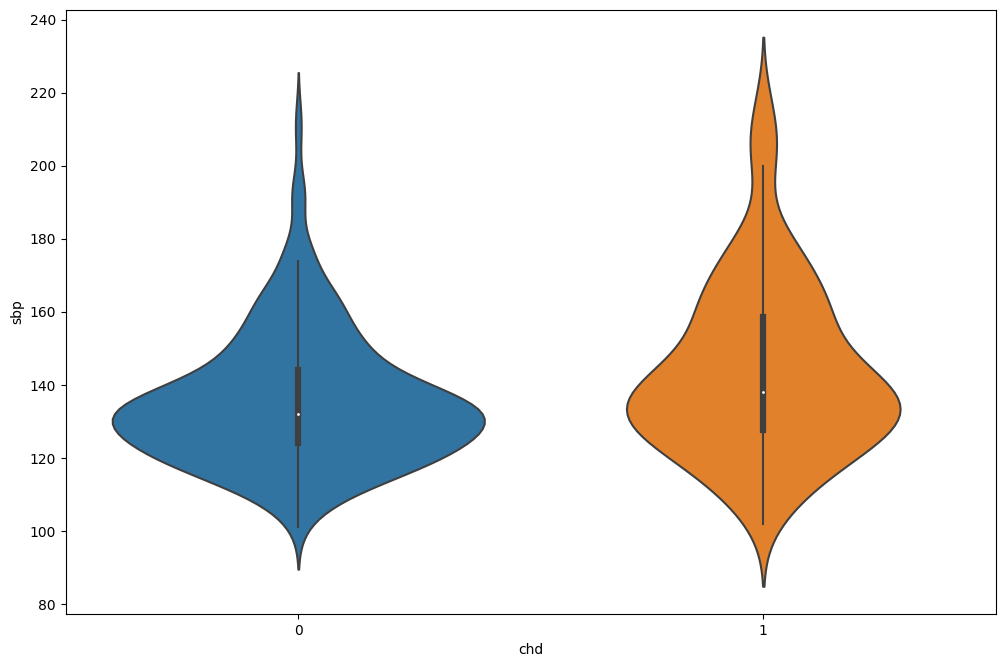

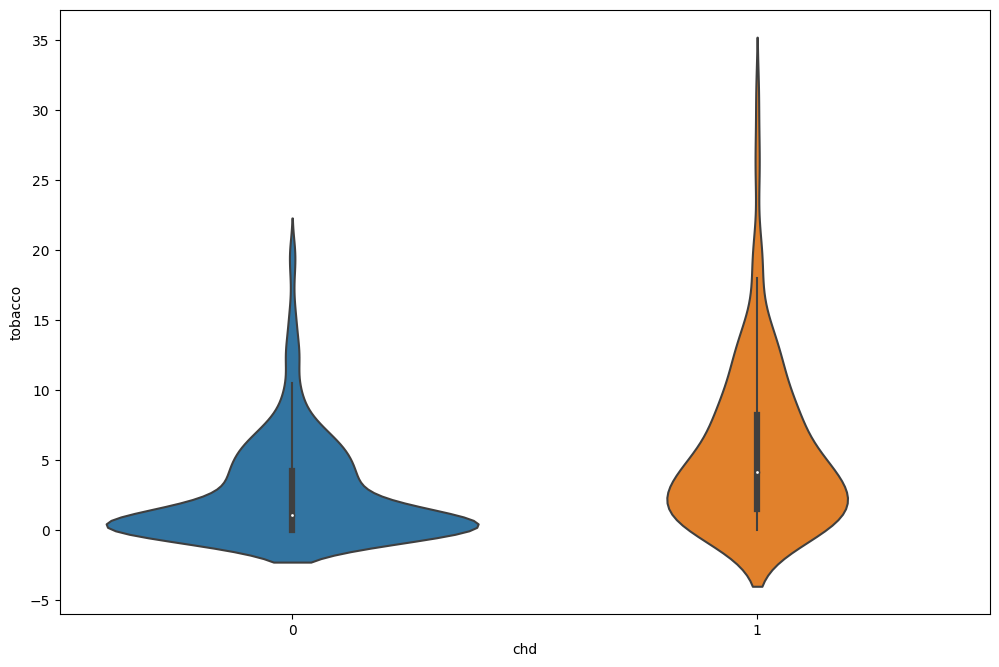

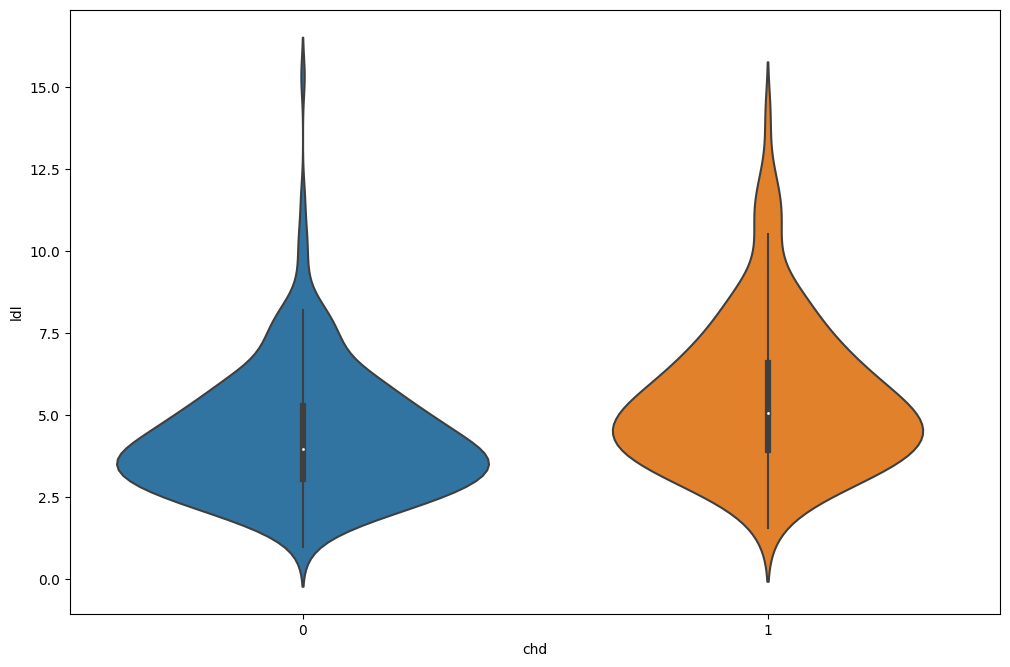

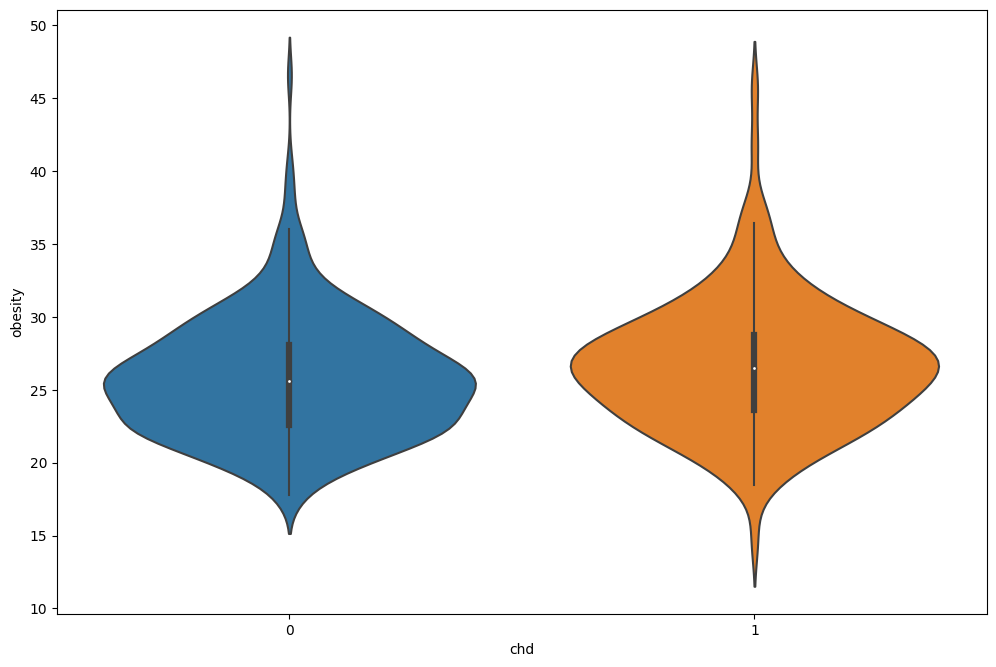

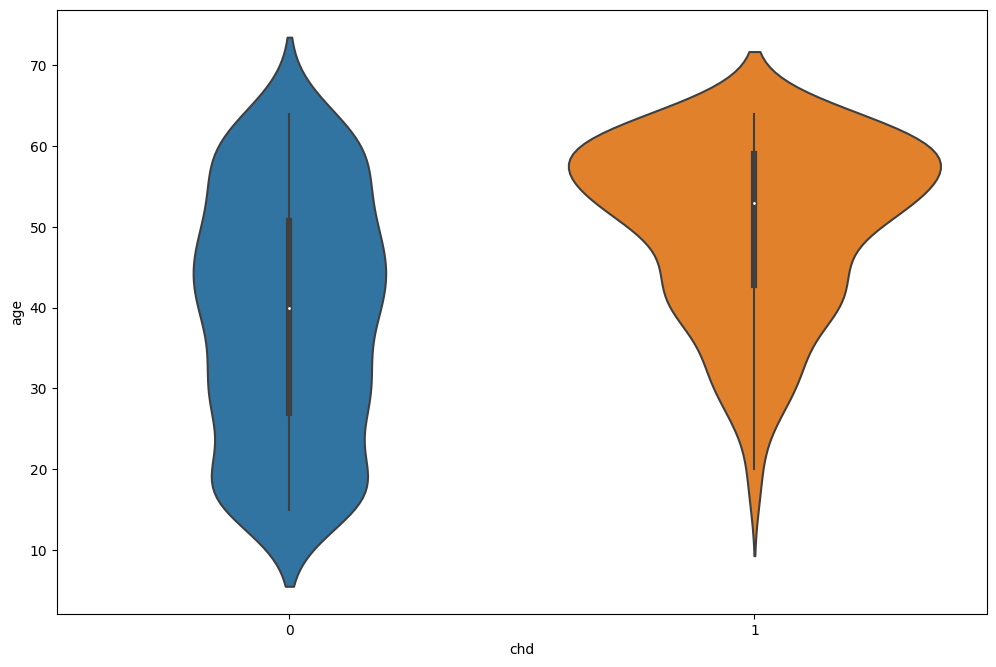

In [208]:
for var in dat.drop(columns=['chd', 'famhist']).columns:
    plt.figure()
    sns.violinplot(x='chd', y=var, data=dat)

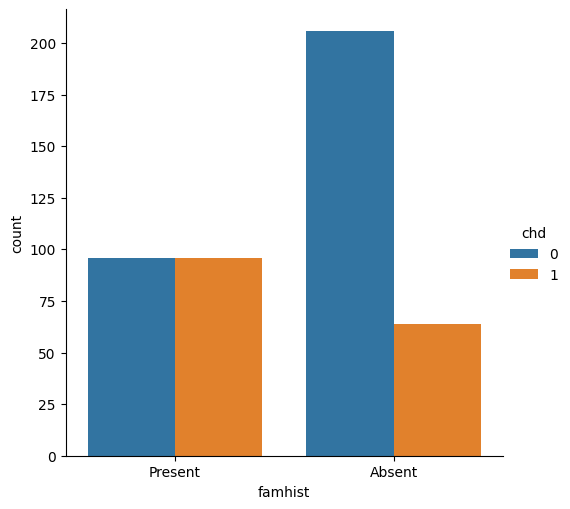

In [209]:
sns.catplot(x='famhist', hue='chd', kind='count', data=dat);

### Modeling
- Note: `statsmodels` module outcome variable and design matrix can only include numeric variables
- We can either 
    - use formula that indicates that a variable is categorical
    - manually create dummy variables for categorical data

- Using an R-style formula with `from_formula`
    - Reference: `C` operator converts numeric categorical variables to dummies

In [210]:
fml = 'chd ~ sbp + tobacco + ldl + famhist + obesity + age'
results = sm.GLM.from_formula(
    fml, data=dat, family=sm.families.Binomial()).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                            GLM   Df Residuals:                      455
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -241.60
Date:                Thu, 18 Feb 2021   Deviance:                       483.19
Time:                        17:21:46   Pearson chi2:                     458.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.1278      0.964     -4.283      0.000      -6.017      -2.239
famhist[T.Present]     0.9413      0.224      4.196      0.000       0.502       1.381
sbp                    0.0059      0.006      1.050      0.294      -0.005       0.017
tobacco                0.0802      0.026      3.117      0.002       0.030       0.131
ldl                    0.1842      0.057      3.218      0.001       0.072       0.296
obesity               -0.0345      0.029     -1.187      0.235      -0.092       0.022
age                    0.0424      0.010      4.187      0.000       0.023       0.062
======================================================================================
"""

- can also give outcome vector and design matrix as inputs
- Note: using `Logit` this time

In [211]:
exog = dat.drop(columns='chd')
exog = sm.add_constant(exog)
exog['famhist'] = dat['famhist'].apply(lambda x: (x == 'Present')*1)
results = sm.Logit(dat.chd, exog).fit()
results.summary()
results.aic

Optimization terminated successfully.
         Current function value: 0.522936
         Iterations 6


497.19253618822677

### Backward-Stepwise Selection
- When prediction is a model goal, including all variables will add random noise to the model
- To avoid this, we perform model selection
- Idea: Remove one variable at a time based on a fit metric (AIC, deviance, BIC, etc)
- Note: Categorical variables with more that two levels are usually split into multiple dummy variables, usually we will want to include or exclude the entire categorical variable.  Stepwise selection can be tricky in this setting
- Algorithm:
    - Compute fit metric for each model removing one variable
    - Chose model with best fit
    - Continue until removing variable no longer improves fit
- Coding note: remember DRY (don't repeat your self)
- Because we will be doing this multiple times, write a function

In [212]:
def back_step(response, exog):
    '''
    Input: response vector, independent (exogenous) variables
    Output: Table of variable removed and corresponding model AIC
    '''
    model_aic = pd.DataFrame(columns=['removed', 'aic'])
    for var in exog.columns:
        inputs = exog.drop(columns=var)
        results = sm.Logit(response, inputs).fit(disp=0)
        aic = results.aic
        model_aic = model_aic.append(
            {'removed': var, 'aic': aic}, ignore_index=True)
    return(model_aic)

back_step(dat.chd, exog)

,removed,aic
0,const,514.220318
1,sbp,496.296748
2,tobacco,505.615194
3,ldl,506.119335
4,famhist,513.067718
5,obesity,496.628362
6,age,513.544698


- Note: Remember that for `statsmodels`, smaller AIC is better
- Should remove `sbp`

In [213]:
back_step(dat.chd, exog.drop(columns='sbp'))

,removed,aic
0,const,515.739097
1,tobacco,504.987650
2,ldl,505.362547
3,famhist,511.931696
4,obesity,495.443861
5,age,517.072595


In [214]:
back_step(dat.chd, exog.drop(columns=['sbp', 'obesity']))

,removed,aic
0,const,595.221755
1,tobacco,504.180276
2,ldl,503.385399
3,famhist,510.824682
4,age,515.242535


- AIC for all of these models greater than 495.44
- Removing any more variables will worsen fit
- Important: standard errors, p-values no longer valid
- Parameters can be interpreted but not CIs

In [215]:
input_dat = exog.drop(columns=['sbp', 'obesity'])
back_step_results = sm.Logit(dat.chd, input_dat).fit(disp=0)
back_step_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Thu, 18 Feb 2021   Pseudo R-squ.:                  0.1856
Time:                        17:21:46   Log-Likelihood:                -242.72
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 5.251e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2043      0.498     -8.436      0.000      -5.181      -3.228
tobacco        0.0807      0.026      3.163      0.002       0.031       0.131
ldl            0.1676      0.054      3.093      0.002       0.061       0.274
famhist        0.9241      0.223      4.141      0.000       0.487       1.362
age            0.0440      0.010      4.520      0.000       0.025       0.063
==============================================================================
"""

- These coefficients are not helpful
- exponentiate the coefficients to make them more interpretable

In [216]:
back_step_results.params.apply(np.exp)

const      0.014932
tobacco    1.084046
ldl        1.182445
famhist    2.519642
age        1.045027
dtype: float64

- interpretation:
    - Compared to someone without a family history of coronary heart disease (CHD), an individual with family history of CHD, is 2.5 times more likely to experience CHD, on average
    - For each year increase in age, an individual is, on average, 1.05 times more likely to experience CHD compared to the previous year
    - again, we cannot use p-values here
- *Post-selection inference* is an active area of research
- If inference is important, you can split the data:
     - fit the model on one split
     - show results with other using model from first split
- Notice that this is the same model we would have arrived at if we had removed insignificant variables from first, full model
- This is not always the case, why?

### Beyond Linearity with Regression Spline Models

- Most of the time, a simple transformation will not be sufficient
- Can be difficult to visualize necessary transformations (logistic regression for example)
- Spline models can make this easier
- Splines maintain a balance between fit and interpretability 
- Splines are piece-wise function, like this
$$
g(x) = \begin{cases}
g_1(x) \qquad x<\xi_1 \\
g_2(x) \qquad \xi_1\leq x < \xi_2 \\
g_3(x) \qquad \xi_3 < x
\end{cases}
$$
- Note: $\xi_1, \xi_2, \xi_3$ are called knots
- For regression, could transform $x$ into 3 variables based on region
$$
\begin{align*}
h_1(x) &= I(x<\xi_1) \\
h_2(x) &= I(\xi_1\leq x < \xi_2),\\
h_3(x) &= I(\xi_3 < x)
\end{align*}
$$
- Note: $h_1, h_2, h_3$ are called basis functions
- We could use this model
$$
g(E[Y|X]) = \beta_1 h_1(x) + \beta_2 h_2(x) + \beta_3 h_3(x)
$$
- Why might this not be ideal?
- What would give give us?
$$
g(E[Y|X=x]) = \beta_1 h_1(x) + \beta_2 h_2(x) + \beta_3 h_3(x) +
\beta_4 h_1(x)x + \beta_5 h_2(x)x + \beta_6 h_3(x)x
$$
- What about these transformations
$$
\begin{align*}
h_1(x) &= 1 \\
h_2(x) &= x \\
h_3(x) &= (x-\xi_1)_+ \\
h_4(x) &= (x-\xi_2)_+
\end{align*}
$$
where
$$(x)_+ =  \begin{cases}
x \qquad x>0 \\
0 \qquad x\leq 0
\end{cases}$$
- Model:
$$
g(E[Y|X=x]) = \sum_{m=1}^4 \beta_m h_m(x)
$$

![](./linearSplinesESL.png)

Image from Elements of Statistical Learning

- It's common to prefer smooth functions over linear splines

- Lower right panel: *cubic spline* has continuous with continuous first and second derivatives at the knots
- It is not difficult to show that these basis function ensure all continuity constraints
$$
\begin{align*}
h_1(x) &= 1 \\
h_2(x) &= x \\
h_3(x) &= x^2 \\
h_4(x) &= x^3 \\
h_5(x) &= (x-\xi_1)_+^3 \\
h_6(x) &= (x-\xi_2)_+^3
\end{align*}
$$
- Parameter count: $(\text{3 regions})\times(\text{4 parameters per region})-(\text{2 knots})\times(\text{3 constraints per knot})=6$
- Higher-order splines?
    - Thought that cubic splines are the lowest-order splines where human eye cannot detect knots
    - Could you find knots if they weren't indicated?
    - Higher order splines are not frequently used in practice
    - Many parameters: must choose order of spline, number of knots and placement
    
![](./cubicSplinesESL.png)

Image from Elements of Statistical Learning



In [217]:
def knot_placement(var, num):
    '''
    input: 
        var: variable as numpy series
        num: number of knots
    output: list of knot placed at quantile locations
    '''
    quants = [(x+1)/(num+1) for x in range(num)]
    return(var.quantile(quants).tolist())

def make_linear_splines(var, knot_locs):
    '''return dataframe for continuous, linear basis'''
    sp_dat = pd.DataFrame(var)
    sp_dat = sm.add_constant(sp_dat)
    for knot in knot_locs:
        knot_name = var.name + "_" +str(int(np.round(knot)))
        sp_dat[knot_name] = var.apply(lambda x: (x-knot)*(x>knot))
    return(sp_dat)

k_locs = knot_placement(dat['age'], 5)
print(k_locs)
lin_age = make_linear_splines(dat['age'], k_locs)
lin_age.head(10)

[27.0, 38.0, 45.0, 52.33333333333326, 59.0]


,const,age,age_27,age_38,age_45,age_52,age_59
0,1.0,52,25.0,14.0,7.0,-0.000000,-0.0
1,1.0,63,36.0,25.0,18.0,10.666667,4.0
2,1.0,46,19.0,8.0,1.0,-0.000000,-0.0
3,1.0,58,31.0,20.0,13.0,5.666667,-0.0
4,1.0,49,22.0,11.0,4.0,-0.000000,-0.0
5,1.0,45,18.0,7.0,0.0,-0.000000,-0.0
6,1.0,38,11.0,0.0,-0.0,-0.000000,-0.0
7,1.0,58,31.0,20.0,13.0,5.666667,-0.0
8,1.0,29,2.0,-0.0,-0.0,-0.000000,-0.0
9,1.0,53,26.0,15.0,8.0,0.666667,-0.0


In [218]:
results = sm.Logit(dat.chd, lin_age).fit()
print(results.aic)
results.summary()

Optimization terminated successfully.
         Current function value: 0.560354
         Iterations 8
531.7670604993787


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      455
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 Feb 2021   Pseudo R-squ.:                  0.1314
Time:                        17:21:46   Log-Likelihood:                -258.88
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 7.860e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8038      2.340     -2.908      0.004     -11.389      -2.218
age            0.1893      0.094      2.017      0.044       0.005       0.373
age_27        -0.0938      0.128     -0.732      0.464      -0.345       0.157
age_38        -0.1396      0.116     -1.208      0.227      -0.366       0.087
age_45         0.1931      0.130      1.486      0.137      -0.062       0.448
age_52        -0.1312      0.126     -1.045      0.296      -0.377       0.115
age_59        -0.0536      0.164     -0.326      0.744      -0.376       0.269
==============================================================================
"""

In [219]:
back_step(dat.chd, lin_age)

,removed,aic
0,const,544.358655
1,age,535.156774
2,age_27,530.323798
3,age_38,531.221126
4,age_45,532.017181
5,age_52,530.862447
6,age_59,529.873510


In [220]:
back_step(dat.chd, lin_age.drop(columns='age_59'))

,removed,aic
0,const,542.452223
1,age,533.254223
2,age_27,528.423363
3,age_38,529.395446
4,age_45,530.549569
5,age_52,530.750804


In [221]:
back_step(dat.chd, lin_age.drop(columns=['age_59', 'age_27']))

,removed,aic
0,const,569.291899
1,age,546.177514
2,age_38,531.032144
3,age_45,530.023171
4,age_52,529.504337


In [236]:
results = sm.Logit(dat.chd, lin_age.drop(
    columns=['age_59', 'age_27'])).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.561064
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Thu, 18 Feb 2021   Pseudo R-squ.:                  0.1303
Time:                        17:30:42   Log-Likelihood:                -259.21
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 5.386e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4017      1.073     -5.034      0.000      -7.505      -3.299
age            0.1282      0.033      3.874      0.000       0.063       0.193
age_38        -0.1940      0.091     -2.122      0.034      -0.373      -0.015
age_45         0.2276      0.122      1.871      0.061      -0.011       0.466
age_52        -0.1635      0.094     -1.745      0.081      -0.347       0.020
==============================================================================
"""

[45.0, 55.0]


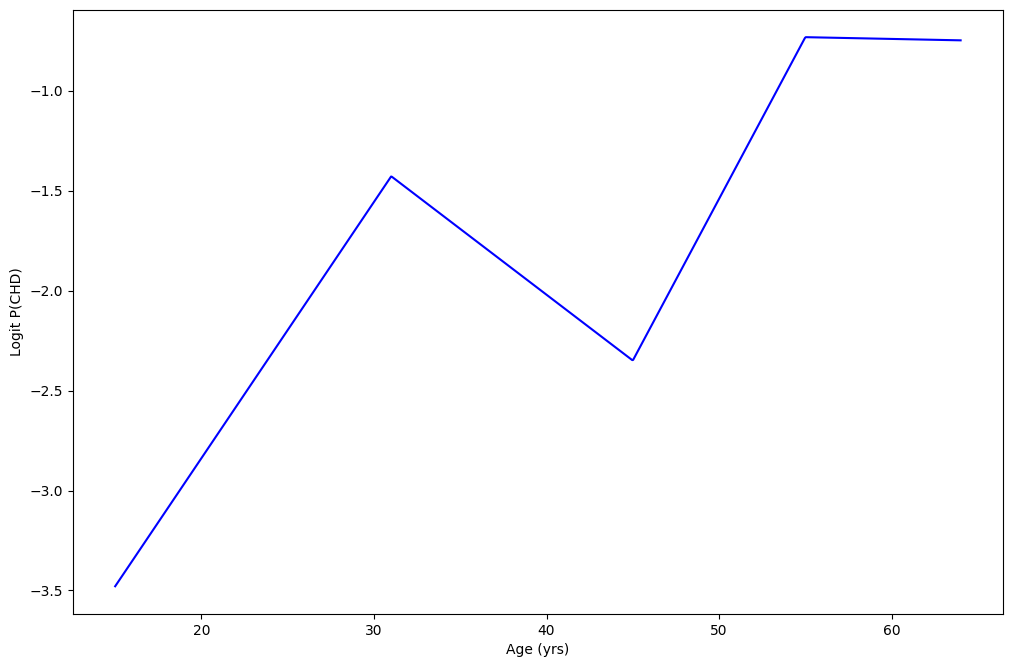

In [237]:
coefs = results.params
x_col = np.linspace(dat['age'].min(), dat['age'].max(), 1000)
locs = k_locs[1:4]
print(locs)
y = np.array([coefs[0]+coefs[1]*x+
              sum([coefs[s+2]*(x-k_locs[s])*(x>k_locs[s]) 
                   for s in range(3)]) for x in x_col])
#y = np.exp(y)
plt.plot(x_col, y, '-b')
plt.xlabel('Age (yrs)')
plt.ylabel('Logit P(CHD)');

In [229]:
def back_select(response, exog):
    '''
    input: binary response variable and exogenous variables
    output: list of selected variables based on backward stepwise
        selection using AIC
    '''
    results = sm.Logit(response, exog).fit(disp=0)
    last_aic = results.aic
    cur_vars = list(exog.columns)
    improvement = True
    while improvement:
        aics = {}
        for var in cur_vars:
            cur_exog = exog[cur_vars].drop(columns=var)
            results = sm.Logit(response, cur_exog).fit(disp=0)
            aics[var] = results.aic
        min_var = min(aics, key=aics.get)
        cur_aic = aics[min_var]
        if cur_aic < last_aic:
            cur_vars.remove(min_var)
            last_aic = cur_aic
        else:
            improvement = False
    return(cur_vars)
        
back_select(dat.chd, lin_age)

['const', 'age', 'age_38', 'age_45', 'age_52']

In [238]:
def make_cubic_splines(var, knot_locs):
    '''return dataframe for continuous, linear basis'''
    sp_dat = pd.DataFrame(var)
    sp_dat = sm.add_constant(sp_dat)
    sp_dat[var.name+"_sqrd"] = var.apply(np.square)
    sp_dat[var.name+"_cubd"] = var.apply(lambda x: x**3)
    for knot in knot_locs:
        knot_name = var.name + "_" +str(int(np.round(knot)))
        sp_dat[knot_name] = var.apply(lambda x: (x-knot)**3*(x>knot))
    return(sp_dat)

k_locs = knot_placement(dat['age'], 3)
print(k_locs)
cube_age = make_cubic_splines(dat['age'], k_locs)
cube_age.head(10)

[31.0, 45.0, 55.0]


,const,age,age_sqrd,age_cubd,age_31,age_45,age_55
0,1.0,52,2704,140608,9261.0,343.0,-0.0
1,1.0,63,3969,250047,32768.0,5832.0,512.0
2,1.0,46,2116,97336,3375.0,1.0,-0.0
3,1.0,58,3364,195112,19683.0,2197.0,27.0
4,1.0,49,2401,117649,5832.0,64.0,-0.0
5,1.0,45,2025,91125,2744.0,0.0,-0.0
6,1.0,38,1444,54872,343.0,-0.0,-0.0
7,1.0,58,3364,195112,19683.0,2197.0,27.0
8,1.0,29,841,24389,-0.0,-0.0,-0.0
9,1.0,53,2809,148877,10648.0,512.0,-0.0


- running backward stepwise

In [240]:
keep_vars = back_select(dat.chd, cube_age)
results = sm.Logit(dat.chd, cube_age[keep_vars]).fit()
print(results.aic)
results.summary()

Optimization terminated successfully.
         Current function value: 0.561503
         Iterations 7
528.8288755657666


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Thu, 18 Feb 2021   Pseudo R-squ.:                  0.1296
Time:                        17:41:29   Log-Likelihood:                -259.41
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 6.563e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.7123      0.189     -3.763      0.000      -1.083      -0.341
age_sqrd       0.0387      0.012      3.258      0.001       0.015       0.062
age_cubd      -0.0005      0.000     -2.972      0.003      -0.001      -0.000
age_31         0.0010      0.000      2.540      0.011       0.000       0.002
age_45        -0.0009      0.000     -1.929      0.054      -0.002    1.47e-05
==============================================================================
"""

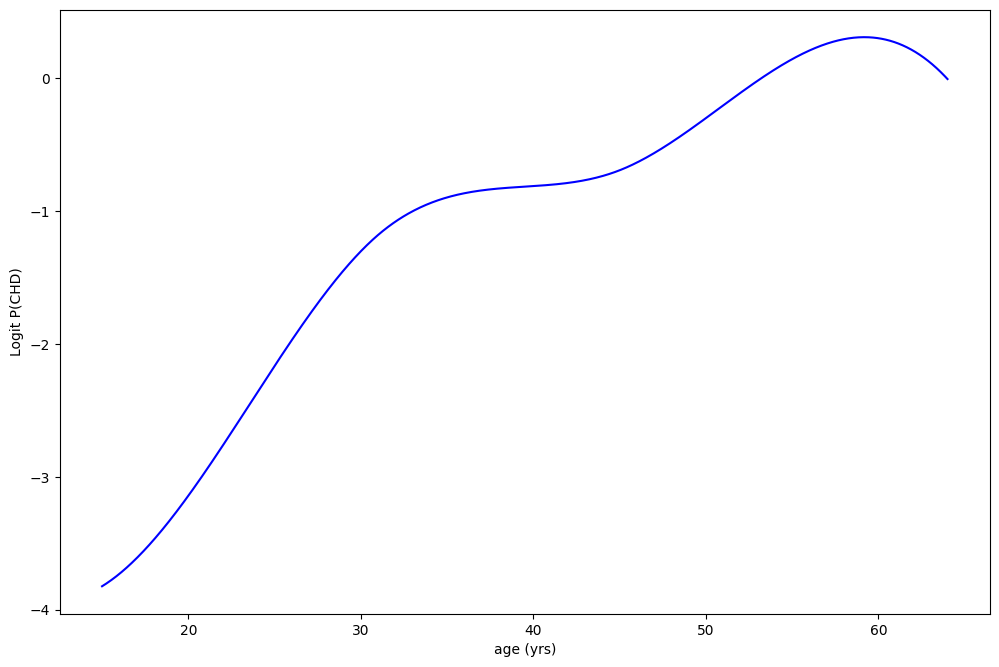

In [283]:
coefs = results.params
x_col = pd.DataFrame({'age': np.linspace(
    dat['age'].min(), dat['age'].max(), 1000)})
x_mat = make_cubic_splines(x_col['age'], k_locs)
x_mat = x_mat[keep_vars]
y = x_mat.dot(coefs)
plt.plot(x_col['age'], y, '-b')
plt.xlabel('age (yrs)')
plt.ylabel('Logit P(CHD)');

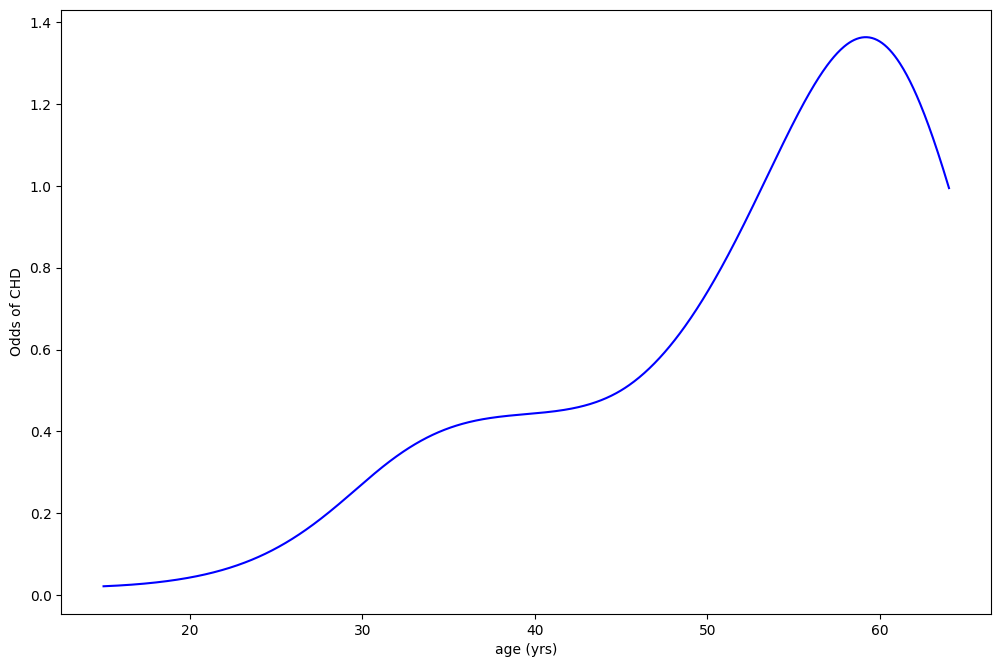

In [284]:
y = x_mat.dot(coefs).apply(np.exp)
plt.plot(x_col['age'], y, '-b')
plt.xlabel('age (yrs)')
plt.ylabel('Odds of CHD');

### Natural Splines

- Issues with regression spline models:
    - Polynomial functions can be erratic near the boundaries
    - And, for all models, extrapolation, predicting values outside of the domain of $x$ within the data, can easily lead to errors
    - These Problems can be worse with splines
- *Natural cubic spline* requires function to be linear beyond boundary knots
- This frees 4 degrees of freedom compared to cubic spline
- Drawback: potentially greater bias near boundary but this acceptable given that there is less information at boundaries
- Natural cubic splines with $K$ knots is represented by $K$ basis functions
$$
N_1(x)=1,\quad N_2(x)=x, \dots,\quad N_{k+2}(x) = d_k(x)-d_{K-1}(x)
$$
where
$$
d_k(x) = \frac{(x-\xi_k)_+^3-(x-\xi_K)_+^3}{\xi_K-\xi_k}
$$
- Each basis function has zero second and third derivatives
- Benefit: once all input variables have been transformed, can apply standard GLM theory

**Fitting Regression Splines**

- To fit regression splines, you need to choose the number of knots/basis functions and knot placement
- To determine the number of basis function, we could use AIC or some other fit metric
    - Note: some models (Likelihood ratio test, deviance) require nested model, AIC doesn't
    - What could go wrong with too many basis functions?
- For natural cubic splines, it's typical to place knots at uniform quantiles
    - e.g. with 3 knots, place each at 1st, 2nd, 3rd quartile
- Equal spacing of knots between max and min is sometimes done as well
- Another approach is to use model selection to select how many knots, removing knots that do not contribute to model fit
- This is a classic method, and can work well provided we choose good knots t1, . . . , tp; but in general choosing knots is a tricky business. There is a large literature on knot selection for regression splines via greedy methods like recursive partitioning (from statistical machine learning at Carnegie Mellon)

![](./overfit.png)

### Smoothing Splines

- Choosing knot locations can be tricky
- *Smoothing splines* circumvent this by placing knots at each input, $x_1, \dots, x_n$ while controlling overfitting by *regularization*
    - **Regularization** adds a penalty for model complexity
- Recall from linear regression, we want to minimize residual sum of squares (RSS):
$$
\text{RSS}(\beta) = \arg\min_\beta \sum_{i=1}^n \left(y_i-x^T\beta\right)^2
$$
where the regression function is $f(x)=x^T\beta$
- For smoothing splines, we want to minimize over all continuous functions with continuous first and second derivatives, plus a complexity term:
$$
\text{RSS}(f,\lambda) = \arg\min_f \sum_{i=1}^n \left[y_i-f(x_i)\right]^2 + \lambda\int[f''(t)]^2 dt
$$
where $\lambda\in(0,\infty)$ is a fixed smoothing parameter that is chosen beforehand
- If $\int[f''(t)]^2dt = 0$, then $f$ is linear
- If $\int[f''(t)]^2dt$ is large, then $f$ is very wiggly
- $\lambda=0 \Rightarrow f$ is any (wiggly) function that interpolates all points
- $\lambda=\infty \Rightarrow f$ is the least squares line from standard regression
- So far, this problem seems very difficult because it is not clear how to estimate $f$, which is assume to be in a *Sobolev function space*
- Remarkably, $f$, the solution to RSS$(f,\lambda)$, has a finite-dimensional (tractable) solution:
    - natural cubic spline with knots at each $x_i$:
    $$
    f(x) = \sum_{j=1}^n N_j(x)\theta_j
    $$
    where $N_j$ is the same as the natural basis function from above
- Once the transformation is done, RSS can be re-written:
$$
\text{RSS}(\theta, \lambda) = (y-N\theta)^T(y-N\theta)+\lambda\theta^T\Omega_N\theta
$$
where $\{N\}_{ij} = N_j(x_i)$ is a matrix ($j$th transformation of $i$ observation and $\Omega_N = \int N_j''(t)N_k''(t)dt$
- Solution:
$$
\hat \theta = (N^TN+\lambda\Omega_N)^{-1} N^Ty
$$

### B-Splines

- These are spline transformations with overlap

![](./bsplineESL.png)

Image from Elements of Statistical Learning

**South African Heart Disease**



### Non-parametric Regression

- Assume $(X,Y)\in \mathbb{R}^d\times\mathbb{R}$ is a random vector
- Regression function
$$
f_0(x)=\mathbb{E}[Y|X=x]
$$
- Goal: estimate $f_0$ from a model $\hat f$ using observation $(X_i,Y_i)\in\mathbb{R}^d\times\mathbb{R}$ for $i=1,\dots,n$
- If the sample, $(x_i,y_i)\in\mathbb{R}^d\times\mathbb{R}$ for $i=1,\dots,n$, is identically, independently distributed (i.i.d.), we generally write
$$
y_i=f_0(x_i)+\epsilon_i
$$
where $\epsilon_i$ is random error with $\mathbb{E}[\epsilon_i]=0$ and $\epsilon_i$ is independent of $x_i$
- In most non-parametric regression settings, it is common to assume that $f_0$ is more complex than a linear function (dot product) of $x_i$ and parameters $\beta$
- But, $f_0$ is almost always assumed to be in some class of functions - For example, we could assume that $f_0$ is an $r$-degree polynomial or that $f_0$ is any function where all $k$th-order partial derivatives are bounded by $L<\infty$
- Fit is generally quantified with the $L_2$ function norm $\|\cdot\|_2$
$$
\|\hat f-f_0\|_2^2=\mathbb{E}\left[(\hat f(x)-f_0(x))^2\right]=\int[\hat f(X)-f_0(X)]^2 p(x)dx
$$
- For a random sample, $(x_i,y_i)\in\mathbb{R}^d\times\mathbb{R}$ for $i=1,\dots,n$, this translates to mean squared error (MSE)
$$
\text{MSE}=\frac{1}{n}\sum_{i=1}^n [\hat f(x_i)-f_0(x_i)]^2 = \frac{1}{n}\sum_{i=1}^n [\hat f(x_i)-y_i]^2
$$

Notes based on [Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. The elements of statistical learning. Vol. 1. No. 10. New York: Springer series in statistics, 2001.](http://statweb.stanford.edu/~tibs/book/preface.ps)